In [246]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers, utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    MaxPooling1D,
    Concatenate,
    GlobalAveragePooling2D,
    Input,
)


# METHOD = 'Librosa'
# train_METHOD = 'Librosa'
# test_METHOD = 'Librosa'

# METHOD = "Morphvox_Pro"
train_METHOD = "Morphvox_Pro"
test_METHOD = "Morphvox_Pro"

# METHOD = "TD-PSOLA"
# train_METHOD = "TD-PSOLA"
# test_METHOD = "TD-PSOLA"


print(
    "Version:%s" % tf.__version__,
    "\nCUDA:%s" % tf.test.is_built_with_cuda(),
    "\nGPU:%s" % tf.test.is_built_with_gpu_support(),
)

Version:2.2.0 
CUDA:True 
GPU:True


In [247]:
trainData = np.load(f"./pre-train/{train_METHOD}/Data-train.npy", allow_pickle=True)
trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train.npy", allow_pickle=True)
validData = np.load("./pre-valid/Librosa/Data-valid.npy", allow_pickle=True)
validLabel = np.load("./pre-valid/Librosa/Label-valid.npy", allow_pickle=True)
pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-pitchShiftTest.npy", allow_pickle=True)
pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-pitchShiftTest.npy", allow_pickle=True)

In [128]:


# trainData = np.load(f"./pre-train/Data-All.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/Label-All.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/Data-All.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/Label-All.npy", allow_pickle=True)

In [248]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(trainLabel)
trainLabel = le.transform(trainLabel)
validLabel = le.transform(validLabel)
pitchShiftTestLabel = le.transform(pitchShiftTestLabel)
# le2 = preprocessing.LabelEncoder()
# le2.fit(melTrainLabel)
# melTrainLabel = le2.transform(melTrainLabel)
# melValidLabel = le2.transform(melValidLabel)

In [217]:
def mlp(shape: int):
    """創建多層感知機
    
    Arguments:
        shape {int} -- [矩陣維度]
    
    Returns:
        Sequential 
    """
    return Sequential(
        [
            Dense(256, input_shape=(shape,), activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(10, activation="softmax"),
        ]
    )


def cnn(shape: tuple):
    """創建多層二維迴旋積分
    
    Arguments:
        shape {tuple} -- [矩陣維度]
    
    Returns:
        Sequential 
    """

    shape1, shape2, shape3 = shape
    inputA = Input((shape2, shape3))
    #     inputB = Input((shape2, shape3))
    x_1 = Conv1D(filters=64, kernel_size=32, activation="relu", padding="same",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(inputA)
    x_1 = MaxPooling1D(pool_size=8, strides=8)(x_1)
    x_1 = Dropout(0.5)(x_1)
    x_1 = Conv1D(
            filters=32, kernel_size=16, strides=4, activation="relu", padding="same",
        )(x_1)
    #     x_1 = MaxPooling1D(pool_size=4, strides=4)(x_1)
    #     x_1 = Dropout(0.5)(x_1)
    x_1 = Flatten()(x_1)
    x_2 = Conv1D(filters=128, kernel_size=32, activation="relu", padding="same",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(
        inputA
    )
    x_2 = MaxPooling1D(pool_size=4, strides=4)(x_2)
    x_2 = Dropout(0.5)(x_2)
    x_2 = Conv1D(
            filters=64, kernel_size=16, strides=18, activation="relu", padding="same",
        )(x_2)
    #     x_2 = MaxPooling1D(pool_size=2, strides=2)(x_2)
    #     x_2 = Dropout(0.5)(x_2)
    x_2 = Flatten()(x_2)

    combined = Concatenate()([x_1, x_2])
    drop_1 = Dropout(0.7)(combined)
    Den_1 = Dense(512, activation="relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(drop_1)
    Den_2 = Dense(512, activation="relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(Den_1)
    #     Den_1 = Dropout(0.5)(Den_1)
    #     Den_1 = Dense(256, activation="relu")(Den_1)
    #     Den_1 = Dropout(0.5)(Den_1)
    Den_3 = Dense(10, activation="softmax")(Den_2)
    model = Model(inputs=inputA, outputs=Den_3)
    return model

In [218]:
model = mlp(trainData.shape[1])
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [249]:
trainLabel = utils.to_categorical(trainLabel)
validLabel = utils.to_categorical(validLabel)
pitchShiftTestLabel = utils.to_categorical(pitchShiftTestLabel)

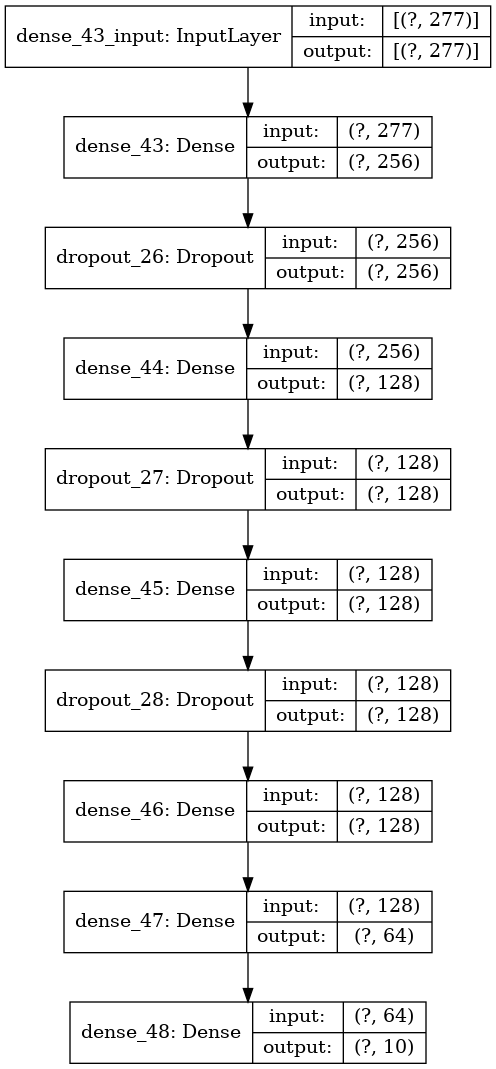

In [219]:
utils.plot_model(
    model, show_shapes=True,
)

In [223]:
history = model.fit(
    trainData,
    trainLabel,
    validation_data=(validData, validLabel),
    verbose=0,  # 不顯示過程
    epochs=100,
    batch_size=128,
)

In [250]:
model.evaluate(validData, validLabel)

4/4 [==============================] - 0s 1ms/step - loss: 0.3717 - accuracy: 0.9400


[0.37169182300567627, 0.9399999976158142]

In [264]:
model.evaluate(pitchShiftTestData[0:100], pitchShiftTestLabel[0:100])

4/4 [==============================] - 0s 1ms/step - loss: 1.2397 - accuracy: 0.7500


[1.239712119102478, 0.75]

In [207]:
model2 = cnn(trainData.reshape(2800, 277, 1).shape)
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

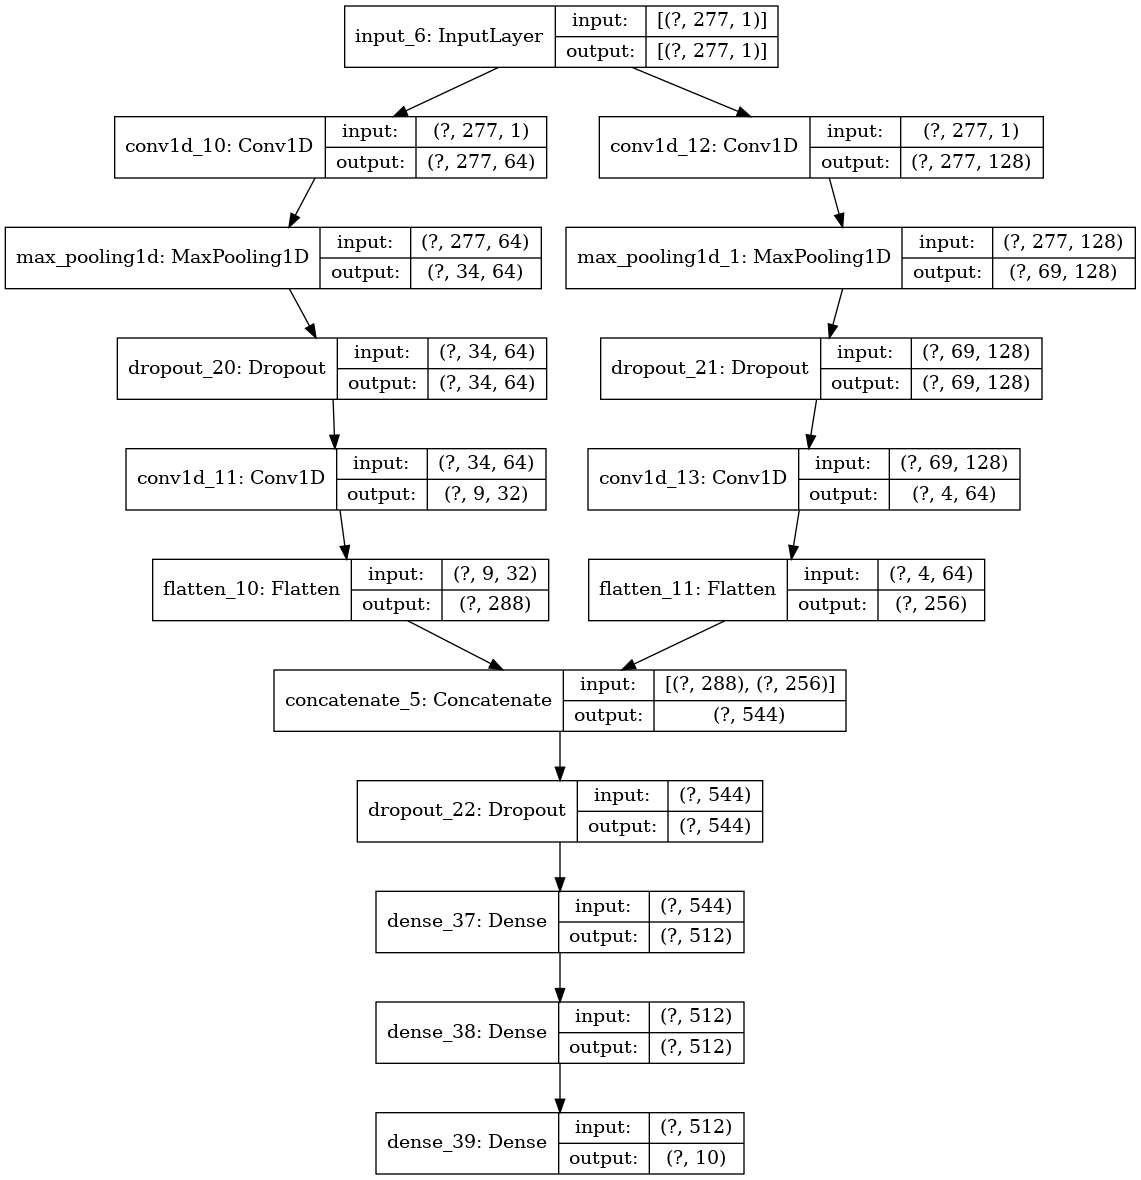

In [181]:
utils.plot_model(
    model2, show_shapes=True,
)

In [ ]:
history2 = model2.fit(
    trainData.reshape(2800, 277, 1),
    trainLabel,
    validation_data=(pitchShiftTestData.reshape(600, 277, 1), pitchShiftTestLabel),
    verbose=1,  # 不顯示過程
    epochs=500,
    batch_size=512,
)

In [243]:
model2.evaluate(validData.reshape(100, 277, 1), validLabel)

4/4 [==============================] - 0s 2ms/step - loss: 0.6355 - accuracy: 0.8200


[0.6355143189430237, 0.8199999928474426]

In [265]:
model2.evaluate(pitchShiftTestData[0:100].reshape(100, 277, 1), pitchShiftTestLabel[0:100])

4/4 [==============================] - 0s 2ms/step - loss: 0.8541 - accuracy: 0.8000


[0.8540940284729004, 0.800000011920929]

In [52]:
len(pitchShiftTestData)

100

In [23]:
trainData

array([[-0.35126988, -0.70720477, -0.37848732, ..., -0.3083759 ,
         0.62191208, -0.53226321],
       [ 1.40049224, -1.29492364,  0.30088059, ...,  0.50249763,
         1.11936624,  0.5171148 ],
       [-0.97207131,  0.8474271 , -0.70652579, ...,  0.27972775,
        -0.90625791, -1.0442017 ],
       ...,
       [-0.47588276, -0.40181509,  0.17681979, ..., -0.81914652,
         0.60787205, -0.37108222],
       [ 1.65267883, -1.1594436 ,  0.42219967, ...,  1.37519449,
         1.16057696,  0.38487696],
       [ 0.70327629, -0.66706698,  0.84890603, ..., -0.72848323,
         1.22470485,  0.22963594]])

In [105]:
trainData = np.load(f"./pre-train/TD-PSOLA/Data-train.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-pitchShiftTest.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-pitchShiftTest.npy", allow_pickle=True)


# trainData = np.load(f"./pre-train/{train_METHOD}/Data-train.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-pitchShiftTest.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-pitchShiftTest.npy", allow_pickle=True)


# trainData = np.load(f"./pre-train/{train_METHOD}/Data-train.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-pitchShiftTest.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-pitchShiftTest.npy", allow_pickle=True)



[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5'),
 Text(0, 5.5, '6'),
 Text(0, 6.5, '7'),
 Text(0, 7.5, '8'),
 Text(0, 8.5, '9'),
 Text(0, 9.5, '10')]

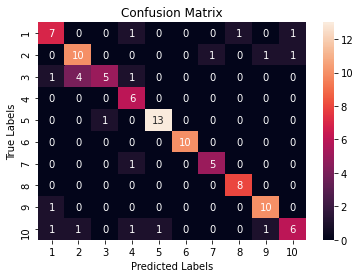

In [266]:
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix

yp=model2.predict(pitchShiftTestData[0:100].reshape(100, 277, 1))
yp=np.argmax(yp,axis=1)
yt=np.argmax(pitchShiftTestLabel[0:100],axis=1)
   

ax= plt.subplot()
cm=confusion_matrix(yt, yp)
sns.heatmap(cm, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5'),
 Text(0, 5.5, '6'),
 Text(0, 6.5, '7'),
 Text(0, 7.5, '8'),
 Text(0, 8.5, '9'),
 Text(0, 9.5, '10')]

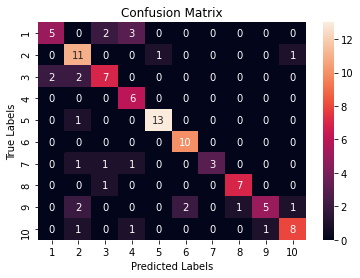

In [267]:
yp=model.predict(pitchShiftTestData[0:100])
yp=np.argmax(yp,axis=1)
yt=np.argmax(pitchShiftTestLabel[0:100],axis=1)
   

ax= plt.subplot()
cm=confusion_matrix(yt, yp)
sns.heatmap(cm, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [260]:
pitchShiftTestData[0:100].shape

(100, 277)